In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path as osp

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet34

from nscl.clevr_object_dataset import CLEVRObjectDataset


In [3]:
#fix random seed
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
torch.manual_seed(2019)
torch.cuda.manual_seed(2019)
torch.cuda.manual_seed_all(2019)
torch.backends.cudnn.deterministic = True

### Prepare Data

In [4]:
# average obj size [56.586 62.133]
img_preprocess = transforms.Compose([
    # transforms.Grayscale(),
    transforms.Resize(60),
    transforms.CenterCrop(60),
    transforms.ToTensor()
])

train_img_root = os.path.abspath(osp.dirname(os.getcwd())) + '/data/CLEVR_v1.0/images/train'
train_scene_json = os.path.abspath(osp.dirname(os.getcwd())) + '/data/CLEVR_v1.0/scenes/train_scenes.json'
val_img_root = os.path.abspath(osp.dirname(os.getcwd())) + '/data/CLEVR_v1.0/images/val'
val_scene_json = os.path.abspath(osp.dirname(os.getcwd())) + '/data/CLEVR_v1.0/scenes/val_scenes.json'

train_dataset = CLEVRObjectDataset(train_img_root, train_scene_json, img_transform=img_preprocess, max_size=1000)
test_dataset = CLEVRObjectDataset(train_img_root, train_scene_json, img_transform=img_preprocess, max_size=100)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

### Model

In [5]:
model = resnet34(pretrained=True)
model.fc = nn.Linear(512, len(train_dataset.classes))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Freeze layers by not tracking gradients
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True #unfreeze last layer weights
model.fc.bias.requires_grad = True #unfreeze last layer biases

### Lightning Model

In [7]:
class CLEVRObjectModel(pl.LightningModule):

    def __init__(self):
        super(CLEVRObjectModel, self).__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.model = model
        self.criteria = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = self.criteria(y_hat, y)
        return {'loss': loss}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        val_loss = self.criteria(y_hat, y)
        return {'val_loss': val_loss}

    def configure_optimizers(self):
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3) #only optimise non-frozen layers
        return optimizer

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

### Training

In [8]:
clevr_model = CLEVRObjectModel()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(clevr_model)


/Users/mark/.conda/envs/nscl_reproducability_challenge/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
INFO:lightning:
    | Name                        | Type              | Params
--------------------------------------------------------------
0   | model                       | ResNet            | 21 M  
1   | model.conv1                 | Conv2d            | 9 K   
2   | model.bn1                   | BatchNorm2d       | 128   
3   | model.relu                  | ReLU              | 0     
4   | model.maxpool               | MaxPool2d         | 0     
5   | model.layer1                | Sequential        | 221 K 
6   | model.layer1.0              | BasicBlock        | 73 K  
7   | model.layer1.0.conv1        | Conv2d            | 36 K  
8   | model.layer1.0.bn

1

tensor([[-0.6003, -0.6378, -0.2630]], grad_fn=<AddmmBackward>)
The predicted class is cube
The target is cube


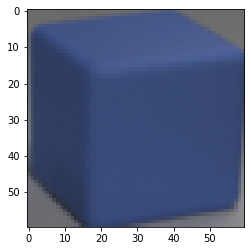

In [9]:
img, target = test_dataset[0]
prediction = clevr_model(img.unsqueeze(0))

predicted_class = test_dataset.classes[prediction.argmax(1).cpu()]
print(prediction)
print('The predicted class is', predicted_class)
print('The target is', test_dataset.classes[target])
plt.imshow(img.permute(1, 2, 0))
plt.show()